# Base Neural Network
How does CLIP compare to other Neural Network Models for Image Classification?

In [1]:
import os

image_dir = "data/"
all_images = [x for x in os.listdir(image_dir) if x.endswith('.jpg')]
categories = set([x[:-8] for x in all_images])
category2images = {category : [] for category in categories}
for img in all_images:
    category2images[img[:-8]].append(img)

all_images

['bagel000.jpg',
 'bagel001.jpg',
 'bagel002.jpg',
 'bagel003.jpg',
 'bagel004.jpg',
 'bagel005.jpg',
 'bagel006.jpg',
 'bagel007.jpg',
 'bagel008.jpg',
 'bagel009.jpg',
 'bagel010.jpg',
 'bagel011.jpg',
 'bagel012.jpg',
 'bagel013.jpg',
 'bagel014.jpg',
 'bagel015.jpg',
 'bagel016.jpg',
 'bagel017.jpg',
 'bagel018.jpg',
 'bagel019.jpg',
 'bagel020.jpg',
 'bagel021.jpg',
 'bagel022.jpg',
 'bagel023.jpg',
 'bagel024.jpg',
 'bagel025.jpg',
 'bagel026.jpg',
 'bagel027.jpg',
 'bagel028.jpg',
 'bagel029.jpg',
 'bagel030.jpg',
 'bagel031.jpg',
 'bagel032.jpg',
 'bagel033.jpg',
 'bagel034.jpg',
 'bagel035.jpg',
 'bagel036.jpg',
 'bagel037.jpg',
 'bagel038.jpg',
 'bagel039.jpg',
 'bagel040.jpg',
 'bagel041.jpg',
 'bagel042.jpg',
 'bagel043.jpg',
 'bagel044.jpg',
 'bagel045.jpg',
 'bagel046.jpg',
 'bagel047.jpg',
 'bagel048.jpg',
 'bagel049.jpg',
 'bagel050.jpg',
 'bagel051.jpg',
 'bagel052.jpg',
 'bagel053.jpg',
 'bagel054.jpg',
 'bagel055.jpg',
 'bagel056.jpg',
 'bagel057.jpg',
 'bagel058.jpg

### Start implementing Base Neural Network

In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

In [4]:
classes = sorted(list(set([name[:-7] for name in all_images])))
print(f"Found {len(all_images)} images across {len(classes)} classes.")
print(classes)

Found 2502 images across 20 classes.
['bagel', 'banana', 'broccoli', 'burrito', 'cabbage', 'cucumber', 'eggnog', 'hotdog', 'ice_cream', 'jackfruit', 'lemon', 'mashed_potato', 'meat_loaf', 'mushroom', 'pineapple', 'pizza', 'pomegranate', 'potpie', 'pretzel', 'strawberry']


In [5]:
# Map each class to numbers for neural network training:
classtoidx = {c:i for i,c in enumerate(classes)}
idxtoclass = {i:c for c,i in classtoidx.items()}

samples = []
for name in all_images:
    clas = name[:-7]
    if clas not in classtoidx:
        continue
    path = os.path.join(image_dir, name)
    samples.append((path, classtoidx[clas]))
print("Example sample:", samples[:3])

Example sample: [('data/bagel000.jpg', 0), ('data/bagel001.jpg', 0), ('data/bagel002.jpg', 0)]


In [6]:
# Prep data:
class FoodDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

def load_food_data(image_dir):
    all_images = [x for x in os.listdir(image_dir) if x.endswith('.jpg')]
    img_paths = []
    labels = []
    
    classes = sorted(list(set([name[:-7] for name in all_images])))
    print(f"Found {len(all_images)} images across {len(classes)} classes.")
    print(classes)
    
    classtoidx = {clas: idx for idx, clas in enumerate(classes)}
    for filename in all_images:
        img_paths.append(os.path.join(image_dir, filename))
        class_name = ''.join([c for c in os.path.splitext(filename)[0] if c.isalpha() or c == '_'])
        labels.append(classtoidx[class_name])
    
    split = int(0.8 * len(img_paths)) # 80/20 split of train and test data
    indices = np.random.permutation(len(img_paths))
    
    train_paths = [img_paths[i] for i in indices[:split]]
    train_labels = [labels[i] for i in indices[:split]]
    test_paths = [img_paths[i] for i in indices[split:]]
    test_labels = [labels[i] for i in indices[split:]]
    
    return train_paths, train_labels, test_paths, test_labels, classes

In [7]:
# Data transformation:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Matches pixels of images we are using
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_dir = "data/"
train_paths, train_labels, test_paths, test_labels, classes = load_food_data(image_dir)

batch_size = 20
trainset = FoodDataset(train_paths, train_labels, transform=transform)
testset = FoodDataset(test_paths, test_labels, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Found 2502 images across 20 classes.
['bagel', 'banana', 'broccoli', 'burrito', 'cabbage', 'cucumber', 'eggnog', 'hotdog', 'ice_cream', 'jackfruit', 'lemon', 'mashed_potato', 'meat_loaf', 'mushroom', 'pineapple', 'pizza', 'pomegranate', 'potpie', 'pretzel', 'strawberry']


In [8]:
# Implement Neural Network:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the Neural Network:
net = Net(num_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 20
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels_batch = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}")

# Save the trained model
path = './food_net.pth'
torch.save(net.state_dict(), path)
print(f"Model saved to {path}")

Training...


Epoch 1 of 20: 100%|██████████████████████████| 101/101 [00:08<00:00, 12.11it/s]


Epoch 1, Loss: 2.9889


Epoch 2 of 20: 100%|██████████████████████████| 101/101 [00:09<00:00, 10.31it/s]


Epoch 2, Loss: 2.9216


Epoch 3 of 20: 100%|██████████████████████████| 101/101 [00:11<00:00,  8.76it/s]


Epoch 3, Loss: 2.7428


Epoch 4 of 20: 100%|██████████████████████████| 101/101 [00:11<00:00,  9.12it/s]


Epoch 4, Loss: 2.5461


Epoch 5 of 20: 100%|██████████████████████████| 101/101 [00:11<00:00,  9.13it/s]


Epoch 5, Loss: 2.4336


Epoch 6 of 20: 100%|██████████████████████████| 101/101 [00:10<00:00,  9.62it/s]


Epoch 6, Loss: 2.2895


Epoch 7 of 20: 100%|██████████████████████████| 101/101 [00:10<00:00,  9.86it/s]


Epoch 7, Loss: 2.1250


Epoch 8 of 20: 100%|██████████████████████████| 101/101 [00:10<00:00,  9.56it/s]


Epoch 8, Loss: 1.9615


Epoch 9 of 20: 100%|██████████████████████████| 101/101 [00:10<00:00,  9.90it/s]


Epoch 9, Loss: 1.8421


Epoch 10 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.40it/s]


Epoch 10, Loss: 1.6533


Epoch 11 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.60it/s]


Epoch 11, Loss: 2.0823


Epoch 12 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.53it/s]


Epoch 12, Loss: 1.7665


Epoch 13 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.77it/s]


Epoch 13, Loss: 1.4593


Epoch 14 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.62it/s]


Epoch 14, Loss: 1.3452


Epoch 15 of 20: 100%|█████████████████████████| 101/101 [00:11<00:00,  9.17it/s]


Epoch 15, Loss: 1.0943


Epoch 16 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.53it/s]


Epoch 16, Loss: 0.8174


Epoch 17 of 20: 100%|█████████████████████████| 101/101 [00:11<00:00,  9.15it/s]


Epoch 17, Loss: 0.7546


Epoch 18 of 20: 100%|█████████████████████████| 101/101 [00:10<00:00,  9.26it/s]


Epoch 18, Loss: 0.7348


Epoch 19 of 20: 100%|█████████████████████████| 101/101 [00:11<00:00,  9.11it/s]


Epoch 19, Loss: 0.3926


Epoch 20 of 20: 100%|█████████████████████████| 101/101 [00:11<00:00,  8.86it/s]


Epoch 20, Loss: 0.2420
Model saved to ./food_net.pth


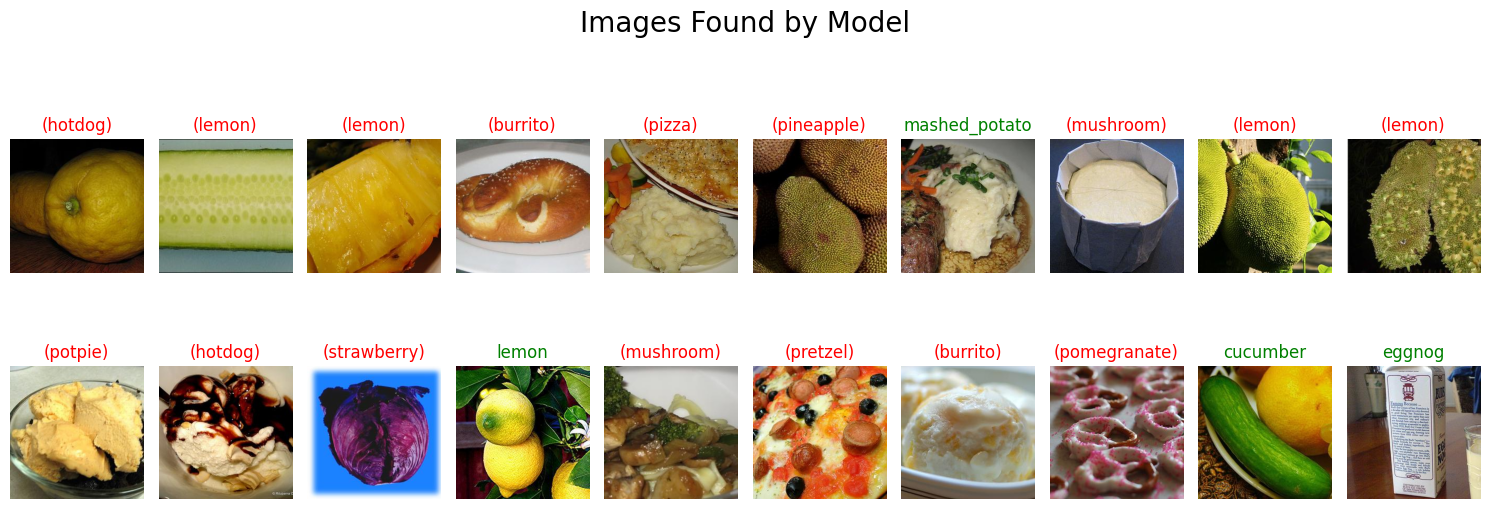

In [9]:
# Test Trained Neural Network Model:
dataiter = iter(testloader)
images, labels_batch = next(dataiter)

model = Net(num_classes=len(classes))
model.load_state_dict(torch.load(path))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

# Visualize predictions
plt.figure(figsize=(15, 6))
for i in range(min(batch_size, len(images))):
    plt.subplot(2, int(batch_size/2), i + 1)
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    color = "green" # good/correct
    label = classes[predicted[i]]
    if classes[labels_batch[i]] != classes[predicted[i]]:
        color = "red" #bad/wrong
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Images Found by Model', size=20)
plt.tight_layout()
plt.show()